In [389]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
spark = SparkSession.builder.getOrCreate()
import pandas as pd
import numpy as np


In [2]:
# Read in CSV file 
source = (spark.read.csv("source.csv",
                     sep=",",
                     header=True,
                     inferSchema=True)
     )
dept = spark.read.csv("dept.csv",
                     sep=",",
                     header=True,
                     inferSchema=True)
case = spark.read.csv("case.csv",
                     sep=",",
                     header=True,
                     inferSchema=True)

In [3]:
source, dept, case

(DataFrame[source_id: string, source_username: string],
 DataFrame[dept_division: string, dept_name: string, standardized_dept_name: string, dept_subject_to_SLA: string],
 DataFrame[case_id: int, case_opened_date: string, case_closed_date: string, SLA_due_date: string, case_late: string, num_days_late: double, case_closed: string, dept_division: string, service_request_type: string, SLA_days: double, case_status: string, source_id: string, request_address: string, council_district: int])

In [4]:
source.show(3, truncate = False, vertical = True)

-RECORD 0---------------------------
 source_id       | 100137           
 source_username | Merlene Blodgett 
-RECORD 1---------------------------
 source_id       | 103582           
 source_username | Carmen Cura      
-RECORD 2---------------------------
 source_id       | 106463           
 source_username | Richard Sanchez  
only showing top 3 rows



In [5]:
df = case

In [6]:
df.show(3, truncate = False, vertical = True)

-RECORD 0-----------------------------------------------------
 case_id              | 1014127332                            
 case_opened_date     | 1/1/18 0:42                           
 case_closed_date     | 1/1/18 12:29                          
 SLA_due_date         | 9/26/20 0:42                          
 case_late            | NO                                    
 num_days_late        | -998.5087616000001                    
 case_closed          | YES                                   
 dept_division        | Field Operations                      
 service_request_type | Stray Animal                          
 SLA_days             | 999.0                                 
 case_status          | Closed                                
 source_id            | svcCRMLS                              
 request_address      | 2315  EL PASO ST, San Antonio, 78207  
 council_district     | 5                                     
-RECORD 1----------------------------------------------

In [7]:
df.dtypes

[('case_id', 'int'),
 ('case_opened_date', 'string'),
 ('case_closed_date', 'string'),
 ('SLA_due_date', 'string'),
 ('case_late', 'string'),
 ('num_days_late', 'double'),
 ('case_closed', 'string'),
 ('dept_division', 'string'),
 ('service_request_type', 'string'),
 ('SLA_days', 'double'),
 ('case_status', 'string'),
 ('source_id', 'string'),
 ('request_address', 'string'),
 ('council_district', 'int')]

In [8]:
#rename SLA Duedate to due date
df = df.withColumnRenamed('SLA_due_date', 'case_due_date')

In [9]:
#correct datatypes
df.select("case_closed", "case_late").show(5)

+-----------+---------+
|case_closed|case_late|
+-----------+---------+
|        YES|       NO|
|        YES|       NO|
|        YES|       NO|
|        YES|       NO|
|        YES|      YES|
+-----------+---------+
only showing top 5 rows



In [10]:
# change to boolean values 
df = df.withColumn('case_closed', expr('case_closed == "YES"'))\
.withColumn('case_late', expr('case_late == "YES"'))

In [11]:
df.select("case_closed", "case_late").show(5)

+-----------+---------+
|case_closed|case_late|
+-----------+---------+
|       true|    false|
|       true|    false|
|       true|    false|
|       true|    false|
|       true|     true|
+-----------+---------+
only showing top 5 rows



In [12]:
#set district to string 
df.select('council_district').show(4)

+----------------+
|council_district|
+----------------+
|               5|
|               3|
|               3|
|               3|
+----------------+
only showing top 4 rows



In [13]:
# council_district as a string instead of int
df = df.withColumn('council_district', col('council_district').cast('string'))

In [14]:
#format dates to_timestamp, fmt

fmt = "M/d/yy H:mm"

df = df.withColumn('case_opened_date', to_timestamp('case_opened_date', fmt))\
.withColumn('case_closed_date', to_timestamp('case_closed_date', fmt))\
.withColumn('case_due_date', to_timestamp('case_due_date', fmt))


In [15]:
#standardize address
df = df.withColumn('request_address', trim(lower(df.request_address)))

df.select('request_address').show(5, False)

+-------------------------------------+
|request_address                      |
+-------------------------------------+
|2315  el paso st, san antonio, 78207 |
|2215  goliad rd, san antonio, 78223  |
|102  palfrey st w, san antonio, 78223|
|114  la garde st, san antonio, 78223 |
|734  clearview dr, san antonio, 78228|
+-------------------------------------+
only showing top 5 rows



In [16]:
#padd 0's for council district
df = df.withColumn('council_district', format_string('%03d', col('council_district').cast('int')))

In [17]:
#add zipcode

df = df.withColumn('zipcode', regexp_extract('request_address', r"(\d+$)", 1))

df.select('zipcode').show(5)

+-------+
|zipcode|
+-------+
|  78207|
|  78223|
|  78223|
|  78223|
|  78228|
+-------+
only showing top 5 rows



In [18]:
#create three new columns 'case_age', 'days_to_closed', 'case_lifetime'

df = (
    df.withColumn(
        "case_age", datediff(current_timestamp(), "case_opened_date")
    )
    .withColumn(
        "days_to_closed", datediff("case_closed_date", "case_opened_date")
    )
    .withColumn(
        "case_lifetime",
        when(expr("! case_closed"), col("case_age")).otherwise(
            col("days_to_closed")
        ),
    )
)


In [19]:
df.select(expr('CASE WHEN case_closed == False THEN case_age ELSE days_to_closed END').alias('case_lifetime')).show(3)

+-------------+
|case_lifetime|
+-------------+
|            0|
|            2|
|            1|
+-------------+
only showing top 3 rows



In [20]:
# join the df and dept dataframe using 'dept_division' as common key
# drop columns as needed (keep standardized_dept_name)
# convert dept_subject_to_SLA to boolean

df = (
    df
    # left join on dept_division
    .join(dept, "dept_division", "left")
    # drop all the columns except for standardized name, as it has much fewer unique values
    .drop(dept.dept_division)
    .drop(dept.dept_name)
    .drop(df.dept_division)
    .withColumnRenamed("standardized_dept_name", "department")
    # convert to a boolean
    .withColumn("dept_subject_to_SLA", col("dept_subject_to_SLA") == "YES")
)

In [21]:
#1. How old is the latest (in terms of days past SLA) 
#currently open issue? How long has the oldest (in terms of days since opened) currently opened issue been open?

In [22]:
df.where(df.case_status == 'Open').orderBy(desc(df.SLA_days)).show(1, False, True)

-RECORD 0--------------------------------------------------------
 case_id              | 1013896575                               
 case_opened_date     | 2017-09-22 08:27:00                      
 case_closed_date     | null                                     
 case_due_date        | 2021-08-11 08:30:00                      
 case_late            | false                                    
 num_days_late        | -1318.354167                             
 case_closed          | false                                    
 service_request_type | Signal Timing Modification By Engineer   
 SLA_days             | 1419.00191                               
 case_status          | Open                                     
 source_id            | CRM_Listener                             
 request_address      | 4200  harry wurzbach, san antonio, 78209 
 council_district     | 010                                      
 zipcode              | 78209                                    
 case_age 

In [23]:
#2 How many Stray Animal cases are there?

In [24]:
df.where(df.service_request_type.contains('Stray Animal')).count()

26760

In [25]:
#3 How many service requests that are assigned to the Field Operations department
#(dept_division) are not classified as "Officer Standby" request type (service_request_type)?

In [26]:
df.filter((df.department == 'Field Operations') & (df.service_request_type != 'Officer Standby' )).count()

0

In [27]:
#4 Convert the council_district column to a string column.
df = df.withColumn('council_district', col('council_district').cast('string'))

In [28]:
#5 Extract the year from the case_closed_date column.
df = df.withColumn('case_closed_year', year(col('case_closed_date')))

In [29]:
df.show(1,False, True)

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  el paso st, san antonio, 78207 
 council_district     | 005                                  
 zipcode              | 78207                                
 case_age             | 1316                                 
 days_to

In [30]:
#6 Convert num_days_late from days to hours in new columns num_hours_late
df = df.withColumn('num_hours_late', (col('num_days_late') * 24))

In [31]:
#8 Are there any cases that do not have a request source
value_counts = df.groupBy(col("source_id")).count().orderBy(desc(col('count')))

In [32]:
#Value counts does not mention null or blank anywhere
value_counts.show(20)

+------------+------+
|   source_id| count|
+------------+------+
|CRM_Listener|195416|
|    svcCRMSS|113585|
|     me05816| 19840|
|     NO10960| 19832|
|     mt13131| 19570|
|      139344| 19238|
|      138793| 18735|
|    svcCRMLS| 18445|
|     DS15677| 18103|
|     gp20685| 17556|
|      140508| 17506|
|      139342| 17492|
|     ns16326| 17234|
|      138810| 16173|
|     mp21218| 15817|
|     mc21309| 15747|
|     ss21394| 15607|
|     jw10936| 15088|
|     yc16753| 15080|
|      139345| 14984|
+------------+------+
only showing top 20 rows



In [33]:
#9 What are the top 10 service request types in terms of number of requests?
value_counts = df.groupBy(col("service_request_type")).count().orderBy(desc(col('count')))

In [34]:
value_counts.show(10)

+--------------------+-----+
|service_request_type|count|
+--------------------+-----+
|           No Pickup|86855|
|Overgrown Yard/Trash|65895|
|        Bandit Signs|32910|
|        Damaged Cart|30338|
|Front Or Side Yar...|28794|
|        Stray Animal|26760|
|Aggressive Animal...|24882|
|Cart Exchange Req...|22024|
|Junk Vehicle On P...|21473|
|     Pot Hole Repair|20616|
+--------------------+-----+
only showing top 10 rows



In [35]:
#10 what are the top 10 service request types in terms of average days late?
df.where('case_late=="YES"').groupBy('service_request_type').agg(mean('num_days_late')).sort(desc('avg(num_days_late)')).show(10, False)

+--------------------------------------+------------------+
|service_request_type                  |avg(num_days_late)|
+--------------------------------------+------------------+
|Zoning: Recycle Yard                  |210.89201994318182|
|Zoning: Junk Yards                    |200.20517608494276|
|Structure/Housing Maintenance         |190.20707698509807|
|Donation Container Enforcement        |171.09115313942615|
|Storage of Used Mattress              |163.96812829714287|
|Labeling for Used Mattress            |162.43032902285717|
|Record Keeping of Used Mattresses     |153.99724039428568|
|Signage Requied for Sale of Used Mattr|151.63868055333333|
|Traffic Signal Graffiti               |137.64583330000002|
|License Requied Used Mattress Sales   |128.79828704142858|
+--------------------------------------+------------------+
only showing top 10 rows



In [36]:
#avg the means is diffrent for each deparment
df.where('case_late=="YES"').groupBy('department').agg(mean('num_days_late')).sort(desc('avg(num_days_late)')).show(10, False)

+------------------------+------------------+
|department              |avg(num_days_late)|
+------------------------+------------------+
|Customer Service        |87.68385942150394 |
|DSD/Code Enforcement    |49.38428705358908 |
|Animal Care Services    |23.458633245820124|
|Parks & Recreation      |22.348910457867518|
|Trans & Cap Improvements|10.603064680316946|
|Solid Waste             |7.186821906120899 |
|Metro Health            |6.5438133155476494|
+------------------------+------------------+



In [37]:
#How do number of days late depend on department and request type?
df.select('*').where('case_late=="YES"').groupBy(['service_request_type','department']).agg(mean('num_days_late')).sort(desc('avg(num_days_late)')).show(df.count(), False)

+-----------------------------------------------+------------------------+-------------------+
|service_request_type                           |department              |avg(num_days_late) |
+-----------------------------------------------+------------------------+-------------------+
|Zoning: Recycle Yard                           |DSD/Code Enforcement    |210.89201994318182 |
|Zoning: Junk Yards                             |DSD/Code Enforcement    |200.20517608494276 |
|Structure/Housing Maintenance                  |DSD/Code Enforcement    |190.20707698509807 |
|Donation Container Enforcement                 |DSD/Code Enforcement    |171.09115313942615 |
|Storage of Used Mattress                       |DSD/Code Enforcement    |163.96812829714287 |
|Labeling for Used Mattress                     |DSD/Code Enforcement    |162.43032902285717 |
|Record Keeping of Used Mattresses              |DSD/Code Enforcement    |153.99724039428568 |
|Signage Requied for Sale of Used Mattr         |D

In [38]:
#avg number of days late changes depending on the service and department, cotentgent on eachother.

In [39]:
#1 How many different cases are there by dept

<AxesSubplot:ylabel='department'>

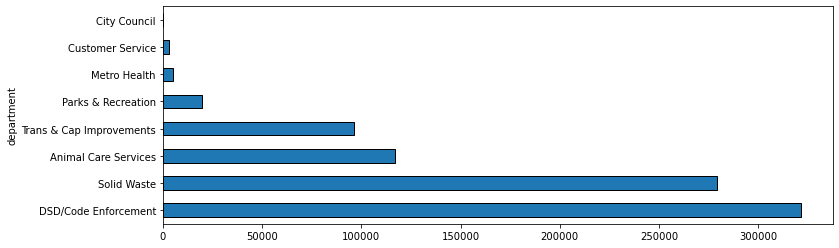

In [48]:
df.groupBy('department').count().toPandas().set_index('department')['count'].sort_values(ascending = False).plot.barh(width=0.5, edgecolor='black', figsize=(12,4))

In [50]:
#Does the percentage of cases that are late vary by department?

In [102]:
temp = (
    df.where('case_late == "YES"')
# group by
    .groupBy("department") 
    .count()
    .toPandas()
    .set_index('department')
)

In [103]:
temp = temp.rename(columns={'count':'num'})

In [104]:
temp['percent'] = (temp.num / temp.groupby('department').num.sum().sum()) * 100

<AxesSubplot:ylabel='department'>

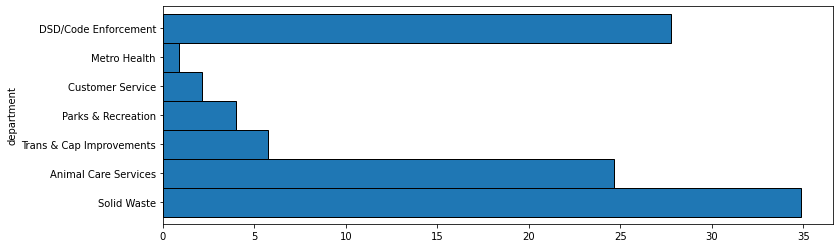

In [110]:
temp.percent.plot.barh(width=1, edgecolor='black',figsize=(12,4))

In [112]:
#3 On average, how late are the late cases by department?

In [119]:
temp = (
    df.where('case_late=="YES"')
# group by
    .groupBy("department") 
    .agg(mean('num_days_late'))
    .toPandas()
    .set_index('department')
)

<AxesSubplot:ylabel='department'>

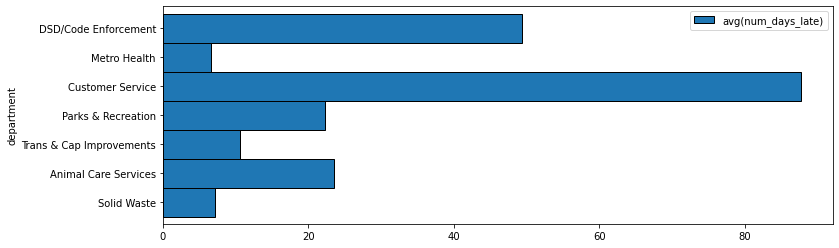

In [123]:
temp.plot.barh(width=1, edgecolor='black',figsize=(12,4))

In [150]:
#4 What is the service type that is the most late? Just for Parks & Rec?
temp = (
    df.where('case_late=="YES"' and 'department == "Parks & Recreation"')
# group by
    .groupBy("service_request_type") 
     .count()
    .toPandas()
    .set_index('service_request_type')
)

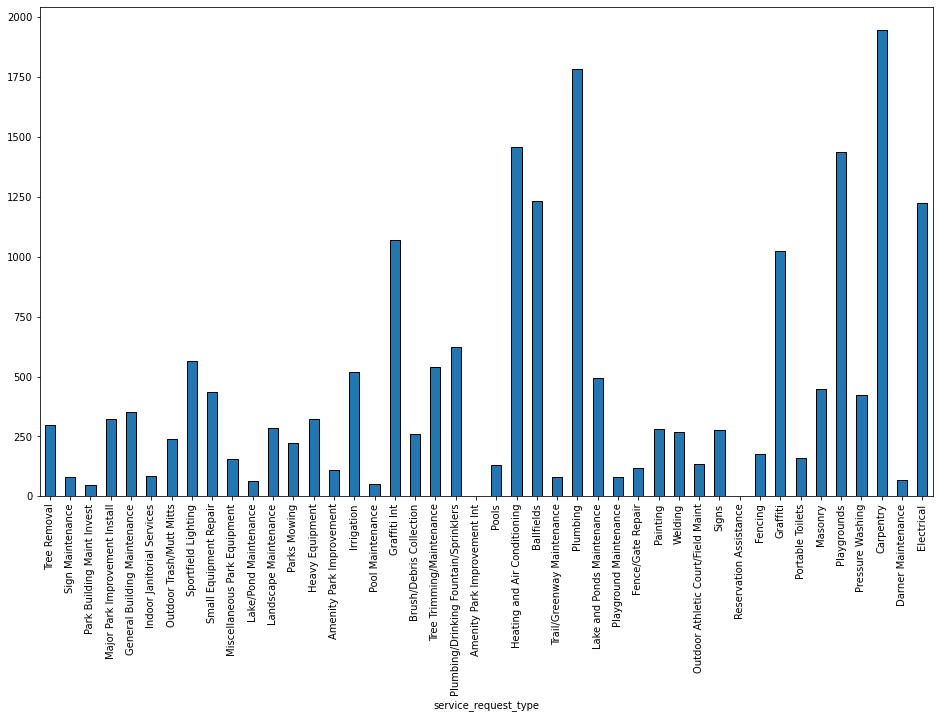

In [151]:
temp.plot.bar(width=0.5, edgecolor='black',figsize=(16,9), legend = False)
ticks, labels = plt.xticks()

In [152]:
#5 For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [173]:
temp = (
    df.where('department=="DSD/Code Enforcement"')
    .groupBy("service_request_type") 
     .count()
    .orderBy(desc('count'))
    .toPandas()
    .set_index('service_request_type')
)

Text(0.5, 1.0, 'Top 20 most popular service types for DSD')

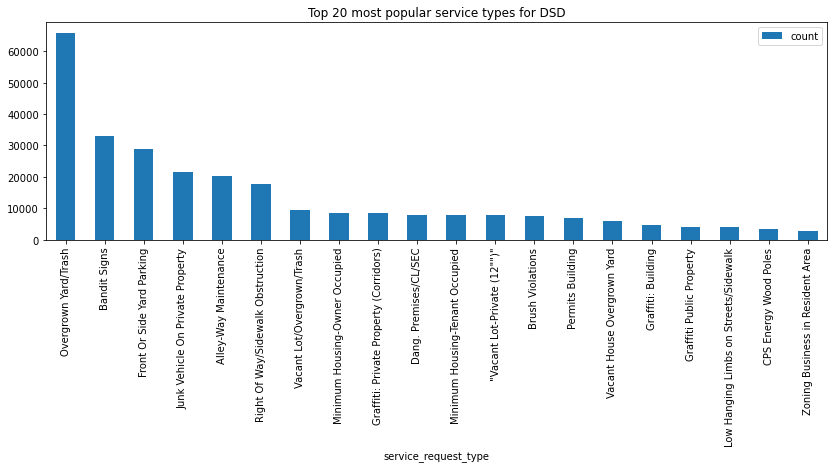

In [174]:
temp.head(20).plot.bar(figsize=(14,4))
plt.title('Top 20 most popular service types for DSD')

In [439]:
temp = (
    df.where('department=="Customer Service"')
    .groupBy("service_request_type") 
     .count()
    .orderBy(desc('count'))
    .toPandas()
    .set_index('service_request_type')
)

Text(0.5, 1.0, 'Service types for customer service')

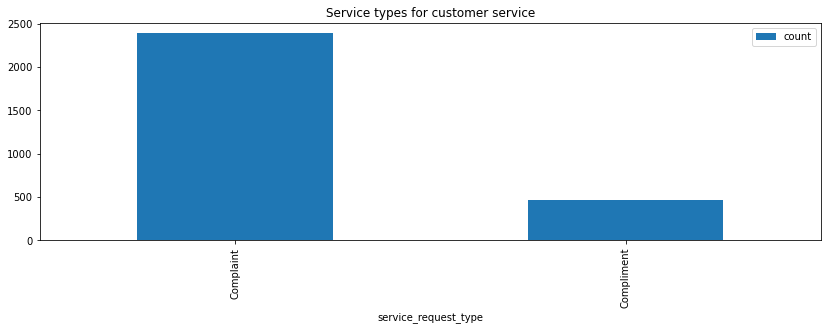

In [441]:
temp.head(20).plot.bar(figsize=(14,4))
plt.title('Service types for customer service')

In [443]:
temp = (
    df.where('department=="Animal Care Services"')
    .groupBy("service_request_type") 
     .count()
    .orderBy(desc('count'))
    .toPandas()
    .set_index('service_request_type')
)

Text(0.5, 1.0, 'Service types for Animal Care Services')

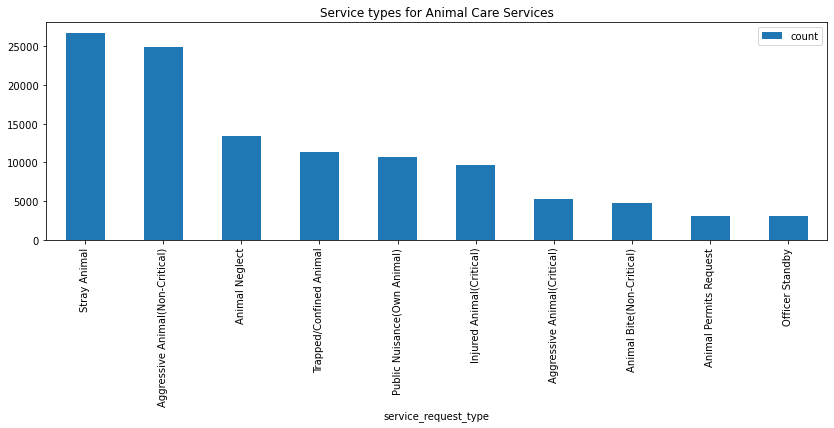

In [445]:
temp.head(10).plot.bar(figsize=(14,4))
plt.title('Service types for Animal Care Services')

In [177]:
#Does whether or not its a weekend matter for when a case is opened/closed?

In [251]:
cases = (
    df
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)

In [253]:
cases = cases.reset_index()

cases['dow'] = cases.case_closed_date.dt.day_name()

Text(0.5, 1.0, 'num of closed cases')

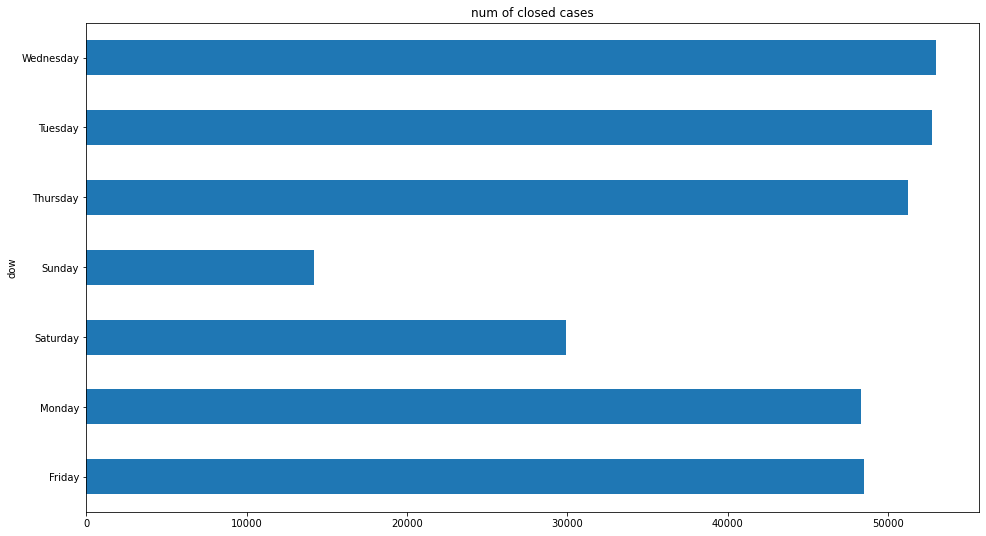

In [254]:
cases.groupby('dow').dow.count().plot.barh(figsize=(16,9))
plt.title('num of closed cases')

In [255]:
cases = (
    df
    .groupby('case_opened_date')
    .count()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)

In [257]:
cases = cases.reset_index()

In [261]:
cases['dow'] = cases.case_opened_date.dt.day_name()

Text(0.5, 1.0, 'num of closed cases')

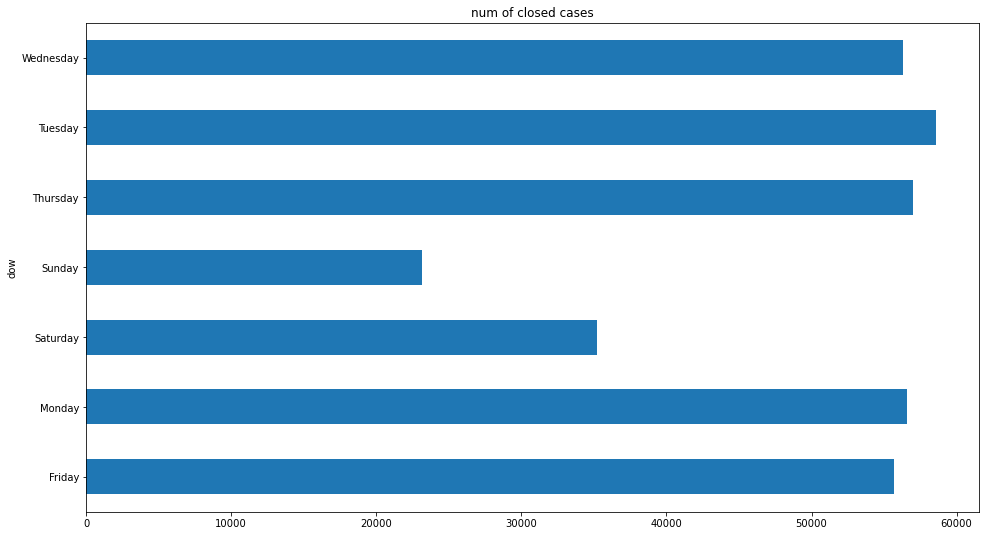

In [263]:
cases.groupby('dow').dow.count().plot.barh(figsize=(16,9))
plt.title('num of closed cases')

In [285]:
# On average, how many cases are opened a day for the Customer Service department?

In [419]:
cases = (
    df.filter(df.department == "Customer Service")
    .groupby("case_opened_date")
    .count()
    .toPandas()
)

<AxesSubplot:xlabel='dow', ylabel='num'>

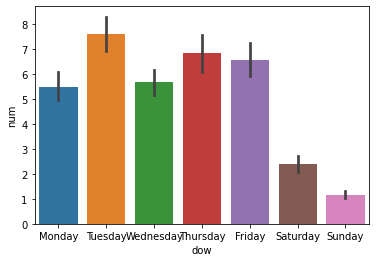

In [420]:
cases = cases.reset_index()
cases['dow'] = cases.case_opened_date.dt.day_name()
cases['case_opened_date_simple'] = cases.case_opened_date.dt.date
cases = cases.rename(columns={'count':'num'})
cases = cases.groupby(['case_opened_date_simple','dow']).num.sum().reset_index()
sns.barplot(data=cases, x='dow', y = 'num')

In [421]:
cases.num.mean()

5.564453125

In [422]:
#Does the number of service requests for the solid waste department vary by day of the week?

In [423]:
cases = (
    df.withColumn("case_opened_date", expr("date(case_opened_date)"))
    .filter(df.department == "Solid Waste")
    .groupby('case_opened_date')
    .count()
    #.toPandas()
)

In [427]:
cases = cases.withColumn("week_day_name", date_format("case_opened_date", "E"))

In [428]:
cases = cases.toPandas().set_index('week_day_name')

In [429]:
cases = cases.groupby(['week_day_name']).mean()

In [430]:
cases

,count
week_day_name,
Fri,616.903614
Mon,691.488095
Sat,184.481928
Sun,81.964286
Thu,574.915663
Tue,691.904762
Wed,499.369048


<AxesSubplot:xlabel='week_day_name'>

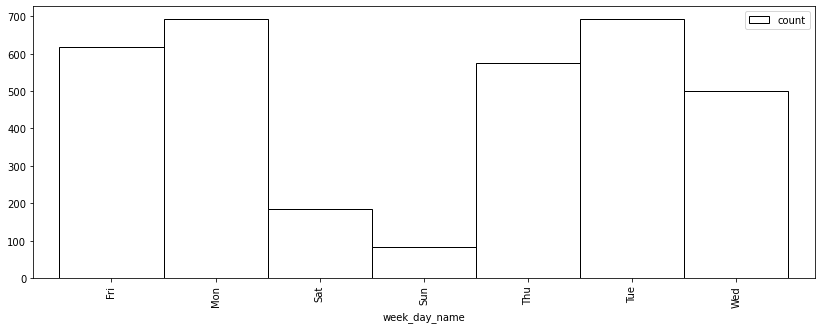

In [438]:
cases.plot.bar(width=1, edgecolor="black", color='white', figsize=(14, 5))